# Лабораторная 1 — Импорт и первичная диагностика  
Участник 1 (Загрузка и диагностика данных)

Цель блока:  
1. Загрузить датасет.  
2. Изучить структуру (размерность, типы, базовые статистики).  
3. Найти явные и скрытые пропуски (нули в физиологических признаках).  
4. Проверить дубликаты.  
5. Сформировать промежуточный «stage 1» датасет для дальнейшего EDA.  

Датасет: diabetes.csv (вариант Pima Indians Diabetes).  
Целевая переменная: `Outcome` (0 — нет диабета, 1 — диабет).  

## Data Dictionary (черновой)

| Признак | Описание | Допустим ли 0 | Комментарий |
|---------|----------|---------------|-------------|
| Pregnancies | Количество беременностей | Да | 0 = не беременна |
| Glucose | Концентрация глюкозы (mg/dL) | Нет | 0 трактуем как пропуск |
| BloodPressure | Диастолическое давление (mm Hg) | Нет | 0 → пропуск |
| SkinThickness | Толщина кожной складки (мм) | Нет | 0 → пропуск |
| Insulin | Инсулин (μU/mL) | Нет | 0 → пропуск |
| BMI | Индекс массы тела | Нет | 0 → пропуск |
| DiabetesPedigreeFunction | Наследственный фактор | Да | 0 возможен (низкий риск) |
| Age | Возраст (годы) | Нет (и не встречается) | |
| Outcome | Целевой признак (0/1) | Да | Бинарный класс |

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda v: f"{v:0.3f}")

In [2]:
FILE_PATH = "../data/raw/diabetes.csv"

df = pd.read_csv(FILE_PATH)
df_raw = df.copy()  # резервная копия исходника

print("Файл загружен.")
print("Размер (rows, cols):", df.shape)
df.head()

Файл загружен.
Размер (rows, cols): (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [3]:
display(df.tail(3))
print("\nИнформация о типах и пропусках (явных):")
df.info()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
765,5,121,72,23,112,26.200,0.245,30,0
766,1,126,60,0,0,30.100,0.349,47,1
767,1,93,70,31,0,30.400,0.315,23,0



Информация о типах и пропусках (явных):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


### Комментарий к типам
Все признаки числовые (`int` / `float`).  
`Outcome` пока оставляем как `int` (бинарный); приводить к `category` не обязательно на этом этапе.  
Явных NaN ещё нет — но в некоторых колонках будут «скрытые» пропуски (нули там, где значения физически не могут быть нулём).

In [6]:
na_counts = df.isna().sum()
print("Явные пропуски (до обработки скрытых):")
na_counts

Явные пропуски (до обработки скрытых):


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [7]:
zero_counts = (df == 0).sum()
zero_pct = (zero_counts / len(df) * 100).round(2)
zero_summary = pd.DataFrame({"zero_count": zero_counts, "zero_pct": zero_pct})
zero_summary.sort_values("zero_pct", ascending=False)

,zero_count,zero_pct
Outcome,500,65.100
Insulin,374,48.700
SkinThickness,227,29.560
Pregnancies,111,14.450
BloodPressure,35,4.560
BMI,11,1.430
Glucose,5,0.650
DiabetesPedigreeFunction,0,0.000
Age,0,0.000


### Решение по скрытым пропускам
Нули в признаках `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, `BMI` физиологически невозможны → интерпретируем как пропуски и заменяем на NaN.  

In [8]:
cols_with_hidden_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

for col in cols_with_hidden_missing:
    df[col] = df[col].replace(0, np.nan)

print("Скрытые пропуски помечены (0 -> NaN) в колонках:", cols_with_hidden_missing)
df[cols_with_hidden_missing].head()

Скрытые пропуски помечены (0 -> NaN) в колонках: ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']


,Glucose,BloodPressure,SkinThickness,Insulin,BMI
0,148.000,72.000,35.000,NaN,33.600
1,85.000,66.000,29.000,NaN,26.600
2,183.000,64.000,NaN,NaN,23.300
3,89.000,66.000,23.000,94.000,28.100
4,137.000,40.000,35.000,168.000,43.100


In [9]:
missing_report = (
    df.isna()
      .sum()
      .to_frame("missing_cnt")
      .assign(missing_pct=lambda x: (x["missing_cnt"] / len(df) * 100).round(2))
      .sort_values("missing_pct", ascending=False)
)
missing_report

,missing_cnt,missing_pct
Insulin,374,48.700
SkinThickness,227,29.560
BloodPressure,35,4.560
BMI,11,1.430
Glucose,5,0.650
Pregnancies,0,0.000
DiabetesPedigreeFunction,0,0.000
Age,0,0.000
Outcome,0,0.000


### Комментарий по пропускам
Наибольшая доля пропусков ожидаемо в `Insulin` и `SkinThickness`.  
Не удаляем строки сейчас: следующему участнику понадобится распределение, а участнику по подготовке данных — стратегия иммутации (медиана / модель / отдельный флаг).

In [10]:
def quality_report(data: pd.DataFrame, zero_as_missing_cols=None):
    if zero_as_missing_cols is None:
        zero_as_missing_cols = []
    rows = []
    n = len(data)
    for col in data.columns:
        # Нули считаем только там, где они допустимы
        zero_cnt = (data[col] == 0).sum() if col not in zero_as_missing_cols else np.nan
        miss_cnt = data[col].isna().sum()
        rows.append({
            "column": col,
            "dtype": str(data[col].dtype),
            "n_unique": data[col].nunique(dropna=True),
            "missing_cnt": miss_cnt,
            "missing_pct": round(miss_cnt / n * 100, 2),
            "zero_cnt": zero_cnt,
            "zero_pct": (round(zero_cnt / n * 100, 2) if not pd.isna(zero_cnt) else np.nan)
        })
    return pd.DataFrame(rows).sort_values("missing_pct", ascending=False)

quality_report(df, cols_with_hidden_missing)

,column,dtype,n_unique,missing_cnt,missing_pct,zero_cnt,zero_pct
4,Insulin,float64,185,374,48.700,NaN,NaN
3,SkinThickness,float64,50,227,29.560,NaN,NaN
2,BloodPressure,float64,46,35,4.560,NaN,NaN
5,BMI,float64,247,11,1.430,NaN,NaN
1,Glucose,float64,135,5,0.650,NaN,NaN
0,Pregnancies,int64,17,0,0.000,111.000,14.450
6,DiabetesPedigreeFunction,float64,517,0,0.000,0.000,0.000
7,Age,int64,52,0,0.000,0.000,0.000
8,Outcome,int64,2,0,0.000,500.000,65.100


In [11]:
dup_cnt = df.duplicated().sum()
print("Количество полных дубликатов:", dup_cnt)
if dup_cnt > 0:
    display(df[df.duplicated(keep=False)].head())

Количество полных дубликатов: 0


### Решение по дубликатам
- Дубликаты не обнаружены — ничего не делаем.  


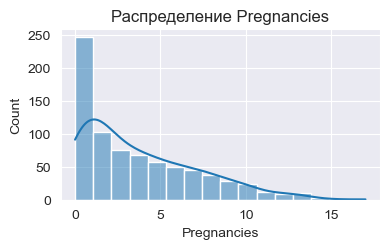

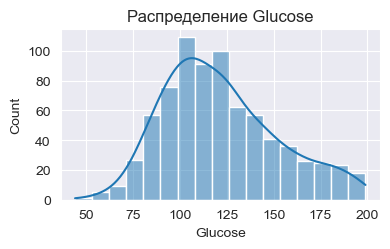

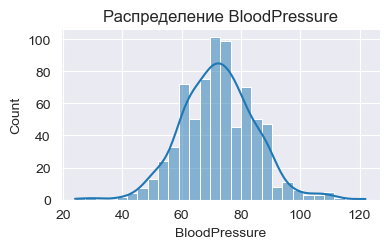

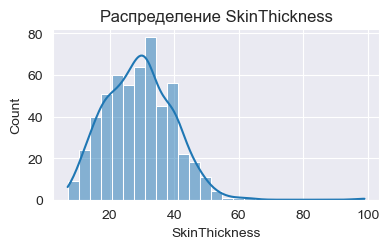

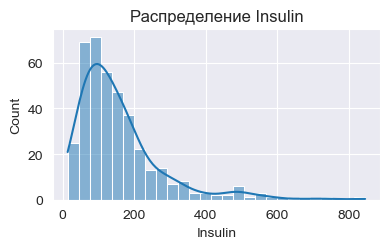

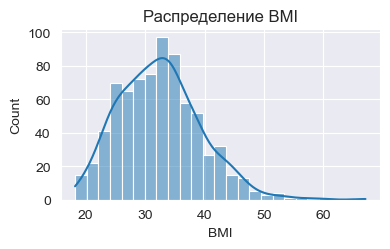

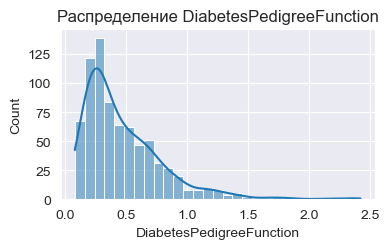

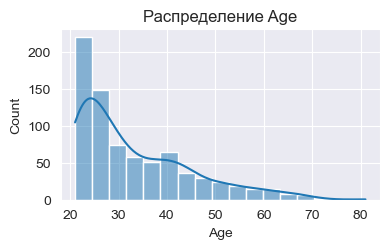

In [12]:
numeric_features = [c for c in df.columns if c != "Outcome"]

for col in numeric_features:
    plt.figure(figsize=(4, 2.6))
    sns.histplot(df[col], kde=True)
    plt.title(f"Распределение {col}")
    plt.tight_layout()
    plt.show()

In [13]:
out_counts = df['Outcome'].value_counts()
out_pct = (out_counts / len(df) * 100).round(2)
print("Распределение классов:")
display(pd.DataFrame({"count": out_counts, "pct": out_pct}))

Распределение классов:


,count,pct
Outcome,,
0,500,65.100
1,268,34.900


### Наблюдения (предварительно)
- Пропуски созданы (0→NaN) в 5 ключевых признаках — значимая доля в `Insulin`, `SkinThickness`.  
- `Outcome` класс: "0" - 65% / "1" - 35%. Небольшой дисбаланс допустим — уточнит участник 2.  
- Распределения скошены (Insulin, BMI, Glucose) — возможна лог-трансформация или робастное масштабирование (этап участника 4).  

In [14]:
OUTPUT_FILE = "../data/interim/diabetes_stage1.csv"
df.to_csv(OUTPUT_FILE, index=False)
print(f"Сохранён промежуточный файл: {OUTPUT_FILE}")

Сохранён промежуточный файл: ../data/interim/diabetes_stage1.csv


## Резюме (Stage 1 готов)

- Строк (после обработки): 768  
- Признаков: 9  
- Скрытые пропуски выявлены и помечены (0→NaN) в колонках: Glucose, BloodPressure, SkinThickness, Insulin, BMI.  
- Наибольшая доля пропусков:
  1) Insulin: 374 (48.70%)
  2) SkinThickness: 227 (29.56%)
  3) BloodPressure: 35 (4.56%)  
- Дубликатов: 0  
- Импутацию не выполняли — оставлено для этапа подготовки данных (участник 4).  
- Промежуточный датасет сохранён: `./data/diabetes_stage1.csv`.  